P(B≥0.80 | A≥0.80) = 1.000  (should be ~1.00)
P(A≥0.80 | B≥0.80) = 0.312  (should be << 1)
P(B≤0.30 | A≤0.30) = 0.000  (keep this LOW)
P(A≤0.30 | B≤0.30) = nan  (keep this LOW)
Saved: synthetic_A_implies_B_not_viceversa_OBVIOUS.csv


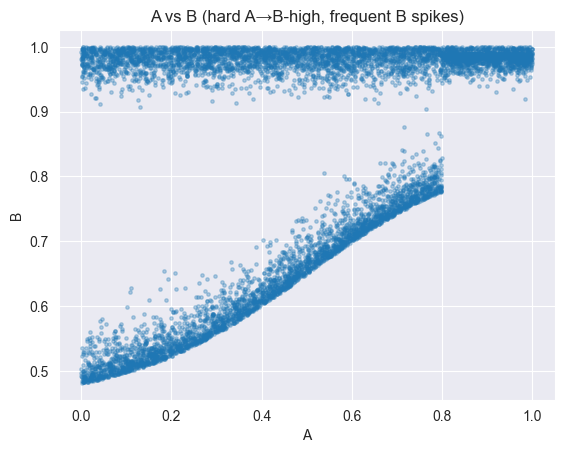

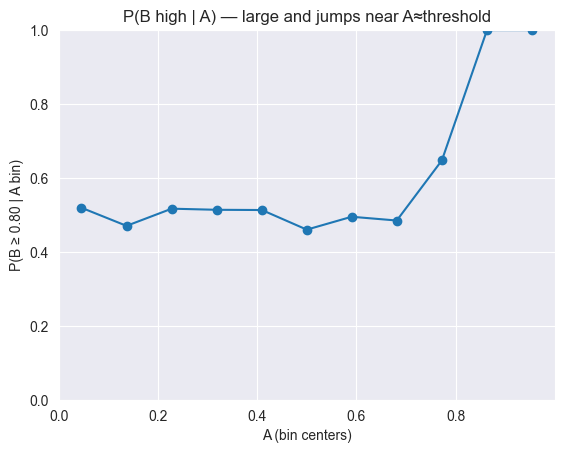

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def safe_mean(mask, values):
    """Return np.nan if mask selects no rows; otherwise the mean over the mask."""
    cnt = np.count_nonzero(mask)
    if cnt == 0:
        return np.nan
    return np.mean(values[mask])

def generate_asymmetric_data(
    n=8000,
    seed=123,
    thr_A_high=0.80,          # definition of "A high"
    thr_B_high=0.80,          # definition of "B high" (for diagnostics only)
    thr_A_low=0.30,           # "A low" (for diagnostics only)
    thr_B_low=0.30,           # "B low" (for diagnostics only)
    spike_p=0.50,             # probability that B gets an independent high spike
    B_floor_if_A_high=0.90    # hard floor for B when A is high (enforces A→B)
):
    rng = np.random.default_rng(seed)

    # A ~ Uniform(0,1) (you can switch to Beta if you want shape)
    A = rng.uniform(0, 1, size=n)

    # Non-linear monotone base for B from A (S-shaped)
    def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))
    base = 0.45 + 0.40 * sigmoid(5 * (A - 0.5))   # ~[0.25, 0.85], non-linear

    # Non-negative noise so we don't break the implication
    eps = rng.gamma(shape=1.0, scale=0.02, size=n)

    # Independent spikes that can make B high regardless of A
    spike_on = rng.binomial(1, spike_p, size=n)
    spike = spike_on * (0.90 + 0.10 * rng.beta(4, 1, size=n))  # ~[0.90, 1.0]

    # Hard floor: if A is high, B is forced high
    floor_high = (A >= thr_A_high) * (B_floor_if_A_high + 0.09 * rng.beta(7, 1, size=n))

    # Combine sources
    B = np.maximum.reduce([base + eps, spike, floor_high])
    B = np.clip(B, 0, 1)

    df = pd.DataFrame({"A": A, "B": B})

    # ---------- Diagnostics (guarded to avoid empty-slice warnings) ----------
    mask_Ahigh = A >= thr_A_high
    mask_Bhigh = B >= thr_B_high
    mask_Alow  = A <= thr_A_low
    mask_Blow  = B <= thr_B_low

    # P(B high | A high)
    p_Bhigh_given_Ahigh = safe_mean(mask_Ahigh, mask_Bhigh.astype(float))

    # P(A high | B high)
    p_Ahigh_given_Bhigh = safe_mean(mask_Bhigh, mask_Ahigh.astype(float))

    # "LOW→LOW" directions (we want these LOW)
    p_Blow_given_Alow = safe_mean(mask_Alow, mask_Blow.astype(float))
    p_Alow_given_Blow = safe_mean(mask_Blow, mask_Alow.astype(float))

    print(f"P(B≥{thr_B_high:.2f} | A≥{thr_A_high:.2f}) = {p_Bhigh_given_Ahigh:.3f}  (should be ~1.00)")
    print(f"P(A≥{thr_A_high:.2f} | B≥{thr_B_high:.2f}) = {p_Ahigh_given_Bhigh:.3f}  (should be << 1)")
    print(f"P(B≤{thr_B_low:.2f} | A≤{thr_A_low:.2f}) = {p_Blow_given_Alow:.3f}  (keep this LOW)")
    print(f"P(A≤{thr_A_low:.2f} | B≤{thr_B_low:.2f}) = {p_Alow_given_Blow:.3f}  (keep this LOW)")

    # ---------- Binning plot without empty-bin warnings ----------
    # Use pandas cut with include_lowest and right=True so edges are handled well.
    bins = np.linspace(0, 1, 12)  # 11 bins
    A_bin = pd.cut(A, bins=bins, include_lowest=True, right=True)
    # Compute P(B high | A bin) safely
    gb = pd.DataFrame({"A_bin": A_bin, "B_high": mask_Bhigh}).groupby("A_bin", observed=True)
    prob_by_bin = gb["B_high"].mean()  # pandas skips empty groups automatically

    centers = prob_by_bin.index.map(lambda iv: (iv.left + iv.right) / 2.0)
    probs = prob_by_bin.values

    # ---------- Save & plots ----------
    df.to_csv("synthetic_A_implies_B_not_viceversa_OBVIOUS.csv", index=False)
    print("Saved: synthetic_A_implies_B_not_viceversa_OBVIOUS.csv")

    # Scatter
    plt.figure()
    plt.scatter(A, B, s=6, alpha=0.3)
    plt.xlabel("A"); plt.ylabel("B")
    plt.title("A vs B (hard A→B-high, frequent B spikes)")
    plt.show()

    # Conditional curve: P(B high | A bin)
    plt.figure()
    plt.plot(centers, probs, marker="o")
    plt.ylim(0, 1)
    plt.xlabel("A (bin centers)")
    plt.ylabel(f"P(B ≥ {thr_B_high:.2f} | A bin)")
    plt.title("P(B high | A) — large and jumps near A≈threshold")
    plt.show()

    return df


df = generate_asymmetric_data()


In [2]:
import FIRM.base.operators.implications as implications
import FIRM.base.operators.tnorms as tnorms
import FIRM.base.fuzzy_data as fuzzy_data
from FIRM.methods.AARFI import AARFI

In [3]:
dataset = df[['A', 'B']]

In [4]:
fuzzy_dataset = fuzzy_data.FuzzyDataQuantiles('symmetric',dataset, 3, ['L', 'M', 'H'])

In [5]:
def marshall_olkin_copula(u, v, alpha=0.487, beta=0.99):
    """
    Marshall–Olkin copula C(u,v; alpha,beta) = min(v*u^(1-alpha), u*v^(1-beta))
    u, v in [0,1]
    """
    u = np.asarray(u)
    v = np.asarray(v)
    term1 = v * u**(1 - alpha)
    term2 = u * v**(1 - beta)
    return np.minimum(term1, term2)

# Example showing asymmetry:
u, v = 0.2, 0.8
C_uv = marshall_olkin_copula(u, v)
C_vu = marshall_olkin_copula(v, u)
print("Marshall–Olkin: C(u,v) =", C_uv, ", C(v,u) =", C_vu)

Marshall–Olkin: C(u,v) = 0.19955421045765648 , C(v,u) = 0.1783672674199353


In [6]:
def gumbel_copula(u, v, theta=2.0):
    """
    Symmetric Gumbel copula.
    """
    u = np.asarray(u)
    v = np.asarray(v)
    # Avoid log(0)
    u = np.clip(u, 1e-10, 1)
    v = np.clip(v, 1e-10, 1)
    term = ((-np.log(u))**theta + (-np.log(v))**theta)**(1/theta)
    return np.exp(-term)

def khoudraji_gumbel(u, v, a=0.8, b=0.2, theta=2.0):
    """
    Khoudraji's asymmetrization of the Gumbel copula.
    """
    u = np.asarray(u)
    v = np.asarray(v)
    # Transformation
    u1 = u**(1 - a)
    v1 = v**(1 - b)
    u2 = u**a
    v2 = v**b
    
    C1 = u1 * v1  # independence part
    C2 = gumbel_copula(u2, v2, theta)
    return C1 * C2

# Example showing asymmetry:
u, v = 0.3, 0.7
C_uv = khoudraji_gumbel(u, v, a=0.9, b=0.1, theta=2.0)
C_vu = khoudraji_gumbel(v, u, a=0.9, b=0.1, theta=2.0)
print("Khoudraji-Gumbel: C(u,v) =", C_uv, ", C(v,u) =", C_vu)

Khoudraji-Gumbel: C(u,v) = 0.21749767478183143 , C(v,u) = 0.2317523423262778


In [7]:
# ============================================================
# Continuous base copulas
# ============================================================
def gumbel(u, v, theta):
    """
    Gumbel copula (theta >= 1). Absolutely continuous on (0,1)^2.
    """
    u = np.clip(u, 1e-12, 1.0); v = np.clip(v, 1e-12, 1.0)
    t = ((-np.log(u))**theta + (-np.log(v))**theta)**(1.0/theta)
    return np.exp(-t)

def clayton(u, v, theta, eps=1e-6):
    """
    Clayton copula, robust to large theta.
    """
    u = np.clip(u, eps, 1.0)  # avoid underflow
    v = np.clip(v, eps, 1.0)
    x = np.maximum(u**(-theta) + v**(-theta) - 1.0, 1e-300)
    return x**(-1.0/theta)

# ============================================================
# Generalized Khoudraji (continuous, asymmetric)
#    C(u,v) = C1(u^(1-a), v^(1-b); th1) * C2(u^a, v^b; th2)
# ============================================================
def khoudraji(u, v, a, b, base1, th1, base2, th2):
    return base1(u**(1.0-a), v**(1.0-b), th1) * base2(u**a, v**b, th2)

# Two continuous families you can toggle: a=0.9989, b=0.4783, th1=1.262, th2=76.170)
def C_GG(u, v, a=0.9989, b=0.4783, th1=1.262, th2=76.170):
    return khoudraji(u, v, a, b, gumbel, th1, gumbel, th2)
#  a=0.9989, b=0.4783, thetaC=1.262, thetaG=76.170
def C_CG(u, v, a, b, th1, th2):
    return khoudraji(u, v, a, b, clayton, th1, gumbel, th2)
def F(x: float, y: float, k: int = 2) -> float:
    """
    Compute F(x, y) = tanh(x) * (y/2)^k for (x,y) in [0,2]^2.

    Parameters
    ----------
    x : float
        First variable, must lie in [0,2].
    y : float
        Second variable, must lie in [0,2].
    k : int, optional
        Exponent controlling asymmetry (default=2).

    Returns
    -------
    float
        Value of F(x,y) in [0,1].
    """
    if not (0 <= x <= 2 and 0 <= y <= 2):
        raise ValueError("x and y must be in [0,2]")
    return float(np.tanh(x) * (y / 2) ** k)

# Example usage
print(F(0.5, 1.5))   # Example evaluation
print(F(1.2, 2.0, k=3))  # With higher k

0.2599409009587555
0.8336546070121552


In [8]:
def C1(x: float, y: float) -> float:
    if np.isclose(x, 0) or np.isclose(y, 0):
        return 0.0
    if y <= (x + 1) / 2:
        return max(y + (x - 1) / 2, 0.0)
    else:
        return x

C = lambda x,y: C_GG(x,y)

def I(x: float, y: float) -> float:
    if x == 0:
        return 1
    if y==1:
        return 1
    else:
        return F(x, y, k=2)/x

In [9]:
I = implications.ImplicationsExamples.get_fuzzy_implication(implications.ImplicationsExamples.IGNORE)
T = tnorms.TnormsExamples.get_tnorm(tnorms.TnormsExamples.PRODUCT)

rules = AARFI(dataset, fuzzy_dataset, T, I, min_cov=0.1, min_supp=0.1, min_conf=0.4, max_feat=3)
measures = rules.measures(fuzzy_dataset)

# Extract measures
num_rules = len(measures['num_features'])
fcoverage = np.mean(measures['fcoverage'])
fsupport = np.mean(measures['fsupport'])
fconfidence = np.mean(measures['fconfidence'])
fwracc = np.mean(measures['fwracc'])

print('num rules: ' + str(len(measures['num_features'])))
print('fcoverage: ' + str(np.mean(measures['fcoverage'])))
print('fsupport: ' + str(np.mean(measures['fsupport'])))
print('fconfidence: ' + str(np.mean(measures['fconfidence'])))
print('fwracc: ' + str(np.mean(measures['fwracc'])))

# Pair each rule with its fconfidence
rules_with_conf = list(zip(rules.rule_list, measures['fconfidence']))

# Sort rules by fconfidence (descending)
rules_with_conf.sort(key=lambda x: x[1], reverse=True)

# Print them in order
for rule, conf in rules_with_conf:
    print(f"fconfidence: {conf:.4f}")
    print(rule)
    print(rule.sentence_rule(fuzzy_dataset))
    print("-" * 40)

num rules: 6
fcoverage: 0.3333333333333333
fsupport: 0.16577311521204965
fconfidence: 0.4949369034698867
fwracc: 0.039090553331397104
fconfidence: 0.5272
<Fuzzy Rule: [(1, 0), (0, 0)]>
IF ( B IS L ) THEN A IS L
----------------------------------------
fconfidence: 0.4995
<Fuzzy Rule: [(1, 1), (0, 2)]>
IF ( B IS M ) THEN A IS H
----------------------------------------
fconfidence: 0.4943
<Fuzzy Rule: [(1, 2), (0, 2)]>
IF ( B IS H ) THEN A IS H
----------------------------------------
fconfidence: 0.4933
<Fuzzy Rule: [(0, 0), (1, 0)]>
IF ( A IS L ) THEN B IS L
----------------------------------------
fconfidence: 0.4808
<Fuzzy Rule: [(0, 1), (1, 0)]>
IF ( A IS M ) THEN B IS L
----------------------------------------
fconfidence: 0.4746
<Fuzzy Rule: [(0, 2), (1, 2)]>
IF ( A IS H ) THEN B IS H
----------------------------------------


In [10]:
import FIRM.base.ct_fuzzy_rule as fuzzy_rule
rule1 = fuzzy_rule.CRFuzzyRule([(0, 2), (1, 2)])
rule2 = fuzzy_rule.CRFuzzyRule([(1, 2),(0, 2)])
rule1.evaluate_rule_database(dataset, fuzzy_dataset, T, I)
rule2.evaluate_rule_database(dataset, fuzzy_dataset, T, I)
print('Support')
print(rule1.fsupport())
print(rule2.fsupport())
print('Confidence')
print(rule1.fconfidence())
print(rule2.fconfidence())

Support
0.1968575136323213
0.1968575136323213
Confidence
0.5271762067164921
0.49431544503291586


In [11]:
results = []

for i in range(len(dataset)):
    x = dataset.iloc[i]

    val1 = rule1.evaluate_rule_example(x, fuzzy_dataset, T, I)
    val2 = rule2.evaluate_rule_example(x, fuzzy_dataset, T, I)

    diff = abs(val1 - val2)

    results.append({
        "index": i,
        "rule1_value": val1,
        "rule2_value": val2,
        "abs_difference": diff
    })

# Convert to DataFrame for a nice view
results_df = pd.DataFrame(results)
results_df

,index,rule1_value,rule2_value,abs_difference
0,0,0.784538,0.784538,0.0
1,1,0.000000,0.000000,0.0
2,2,0.000000,0.000000,0.0
3,3,0.000000,0.000000,0.0
4,4,0.000000,0.000000,0.0
...,...,...,...,...
7995,7995,0.000000,0.000000,0.0
7996,7996,0.000000,0.000000,0.0
7997,7997,0.000000,0.000000,0.0
7998,7998,0.504427,0.504427,0.0


In [12]:
rule1 = fuzzy_rule.CRFuzzyRule([(1, 0), (0, 0)])
rule2 = fuzzy_rule.CRFuzzyRule([(0, 0), (1, 0)])
for i in range(len(dataset)):
    x = dataset.iloc[i]
    print(rule2.evaluate_consequent_example(x, fuzzy_dataset))
    print(rule1.evaluate_consequent_example(x, fuzzy_dataset))
    print(F(rule1.evaluate_antecedent_example(x, fuzzy_dataset, T),rule1.evaluate_consequent_example(x, fuzzy_dataset)))
    print(F(rule1.evaluate_consequent_example(x, fuzzy_dataset),rule1.evaluate_antecedent_example(x, fuzzy_dataset, T)))
    print('----------------')

0
0
0.0
0.0
----------------
1
1
0.1903985389889412
0.1903985389889412
----------------
1
1
0.1903985389889412
0.1903985389889412
----------------
0
1
0.0
0.0
----------------
0
1
0.0
0.0
----------------
0
0
0.0
0.0
----------------
0
0
0.0
0.0
----------------
1
0.8965725669882803
0.1530504124209927
0.17865622321192204
----------------
0
0
0.0
0.0
----------------
0
0
0.0
0.0
----------------
0
0
0.0
0.0
----------------
0
1
0.0
0.0
----------------
0
0
0.0
0.0
----------------
0
1
0.0
0.0
----------------
0
0
0.0
0.0
----------------
0.7869894659054928
0
0.0
0.0
----------------
0.008311428669388499
0
0.0
0.0
----------------
1
1
0.1903985389889412
0.1903985389889412
----------------
0
0
0.0
0.0
----------------
0
0
0.0
0.0
----------------
0.02167716279088061
1
0.005418442016779323
8.94681566923089e-05
----------------
1
1
0.1903985389889412
0.1903985389889412
----------------
0
0
0.0
0.0
----------------
0
0
0.0
0.0
----------------
1
1
0.1903985389889412
0.1903985389889412
------

In [13]:
results = []

for i in range(len(dataset)):
    x = dataset.iloc[i]

    val1 = rule1.evaluate_rule_example(x, fuzzy_dataset, T, I)
    val2 = rule2.evaluate_rule_example(x, fuzzy_dataset, T, I)

    diff = abs(val1 - val2)

    results.append({
        "index": i,
        "rule1_value": val1,
        "rule2_value": val2,
        "abs_difference": diff
    })

# Convert to DataFrame for a nice view
results_df = pd.DataFrame(results)
results_df


,index,rule1_value,rule2_value,abs_difference
0,0,0.000000,0.000000,0.0
1,1,1.000000,1.000000,0.0
2,2,1.000000,1.000000,0.0
3,3,0.000000,0.000000,0.0
4,4,0.000000,0.000000,0.0
...,...,...,...,...
7995,7995,0.000000,0.000000,0.0
7996,7996,0.007297,0.007297,0.0
7997,7997,0.000000,0.000000,0.0
7998,7998,0.000000,0.000000,0.0


In [14]:
EVAL = lambda x,y: T(x,I(x,y))

In [15]:
# Create a grid of x and y values
x_values = np.linspace(0.1, 1.0, 10)  # Avoid 0 due to negative exponent
y_values = np.linspace(0.1, 1.0, 10)

# Evaluate the difference
results = []
for x in x_values:
    for y in y_values:
        try:
            t_xy = T(x, y)
            t_x_ixy = EVAL(x, y)
            difference = np.abs(t_xy - t_x_ixy)
            results.append((x, y, t_xy, t_x_ixy, difference))
        except (ValueError, ZeroDivisionError):
            # Handle potential numerical issues
            results.append((x, y, np.nan, np.nan, np.nan))

# Print results
print("x\t\ty\t\tT(x,y)\t\tT(x,I(x,y))\tDifference")
print("-" * 60)
for x, y, t_xy, t_x_ixy, diff in results:
    print(f"{x:.2f}\t\t{y:.2f}\t\t{t_xy:.6f}\t{t_x_ixy:.6f}\t\t{diff:.6f}")

# Calculate statistics
differences = [diff for _, _, _, _, diff in results if not np.isnan(diff)]
if differences:
    print(f"\nStatistics:")
    print(f"Max difference: {max(differences):.6f}")
    print(f"Min difference: {min(differences):.6f}")
    print(f"Average difference: {np.mean(differences):.6f}")
    print(f"Absolute average: {np.mean(np.abs(differences)):.6f}")
    
    

x		y		T(x,y)		T(x,I(x,y))	Difference
------------------------------------------------------------
0.10		0.10		0.010000	0.010000		0.000000
0.10		0.20		0.020000	0.020000		0.000000
0.10		0.30		0.030000	0.030000		0.000000
0.10		0.40		0.040000	0.040000		0.000000
0.10		0.50		0.050000	0.050000		0.000000
0.10		0.60		0.060000	0.060000		0.000000
0.10		0.70		0.070000	0.070000		0.000000
0.10		0.80		0.080000	0.080000		0.000000
0.10		0.90		0.090000	0.090000		0.000000
0.10		1.00		0.100000	0.100000		0.000000
0.20		0.10		0.020000	0.020000		0.000000
0.20		0.20		0.040000	0.040000		0.000000
0.20		0.30		0.060000	0.060000		0.000000
0.20		0.40		0.080000	0.080000		0.000000
0.20		0.50		0.100000	0.100000		0.000000
0.20		0.60		0.120000	0.120000		0.000000
0.20		0.70		0.140000	0.140000		0.000000
0.20		0.80		0.160000	0.160000		0.000000
0.20		0.90		0.180000	0.180000		0.000000
0.20		1.00		0.200000	0.200000		0.000000
0.30		0.10		0.030000	0.030000		0.000000
0.30		0.20		0.060000	0.060000		0.000000
0.30		0.30		0.090000	0

In [16]:
# Create a grid of x and y values
x_values = np.linspace(0.1, 1.0, 10)  # Avoid 0 due to negative exponent
y_values = np.linspace(0.1, 1.0, 10)

# Evaluate the difference
results = []
for x in x_values:
    for y in y_values:
        try:
            t_xy = C(x, y)
            t_x_ixy = C(y,x)
            difference = np.abs(t_xy - t_x_ixy)
            results.append((x, y, t_xy, t_x_ixy, difference))
        except (ValueError, ZeroDivisionError):
            # Handle potential numerical issues
            results.append((x, y, np.nan, np.nan, np.nan))

# Print results
print("x\t\ty\t\tT(x,y)\t\tT(x,I(x,y))\tDifference")
print("-" * 60)
for x, y, t_xy, t_x_ixy, diff in results:
    print(f"{x:.2f}\t\t{y:.2f}\t\t{t_xy:.6f}\t{t_x_ixy:.6f}\t\t{diff:.6f}")

# Calculate statistics
differences = [diff for _, _, _, _, diff in results if not np.isnan(diff)]
if differences:
    print(f"\nStatistics:")
    print(f"Max difference: {max(differences):.6f}")
    print(f"Min difference: {min(differences):.6f}")
    print(f"Average difference: {np.mean(differences):.6f}")
    print(f"Absolute average: {np.mean(np.abs(differences)):.6f}")
    
    

x		y		T(x,y)		T(x,I(x,y))	Difference
------------------------------------------------------------
0.10		0.10		0.030146	0.030146		0.000000
0.10		0.20		0.043277	0.060254		0.016977
0.10		0.30		0.053470	0.090347		0.036877
0.10		0.40		0.062126	0.099988		0.037861
0.10		0.50		0.069794	0.099991		0.030198
0.10		0.60		0.076755	0.099994		0.023239
0.10		0.70		0.083177	0.099996		0.016819
0.10		0.80		0.089171	0.099998		0.010827
0.10		0.90		0.094807	0.099999		0.005192
0.10		1.00		0.100000	0.100000		0.000000
0.20		0.10		0.060254	0.043277		0.016977
0.20		0.20		0.086502	0.086502		0.000000
0.20		0.30		0.106876	0.129706		0.022829
0.20		0.40		0.124180	0.172896		0.048716
0.20		0.50		0.139508	0.199980		0.060472
0.20		0.60		0.153425	0.199987		0.046562
0.20		0.70		0.166267	0.199992		0.033724
0.20		0.80		0.178253	0.199995		0.021742
0.20		0.90		0.189531	0.199998		0.010467
0.20		1.00		0.200000	0.200000		0.000000
0.30		0.10		0.090347	0.053470		0.036877
0.30		0.20		0.129706	0.106876		0.022829
0.30		0.30		0.160258	0

In [17]:
import numpy as np

# Marshall–Olkin copula
def marshall_olkin_copula(u, v, alpha=0.9, beta=0.2):
    """
    Marshall–Olkin copula C(u,v; alpha,beta) = min(v*u^(1-alpha), u*v^(1-beta))
    u, v in [0,1]
    """
    u = np.asarray(u)
    v = np.asarray(v)
    term1 = v * u**(1 - alpha)
    term2 = u * v**(1 - beta)
    return np.minimum(term1, term2)

def score_for_params(alpha, beta, grid_size=80):
    """
    Compute:
    - mean absolute difference from uv
    - mean absolute difference from C(v,u)
    Returns both plus a combined score = sum.
    """
    U = np.linspace(0.001, 0.999, grid_size)
    UU, VV = np.meshgrid(U, U)
    C_uv = marshall_olkin_copula(UU, VV, alpha, beta)
    C_vu = marshall_olkin_copula(VV, UU, alpha, beta)
    prod = UU * VV
    
    diff_prod = np.abs(C_uv - prod)
    diff_asym = np.abs(C_uv - C_vu)
    
    mean_diff_prod = np.mean(diff_prod)
    mean_diff_asym = np.mean(diff_asym)
    combined_score = mean_diff_asym  # simple additive criterion
    
    return mean_diff_prod, mean_diff_asym, combined_score

# Grid search over alpha,beta
alphas = np.linspace(0.01, 0.99, 40)
betas  = np.linspace(0.01, 0.99, 40)

best_alpha = None
best_beta = None
best_score = -1
best_diff_prod = None
best_diff_asym = None

for a in alphas:
    for b in betas:
        if abs(a - b) < 1e-9:  # skip perfectly symmetric
            continue
        diff_prod, diff_asym, score = score_for_params(a,b)
        if score > best_score:
            best_score = score
            best_alpha = a
            best_beta = b
            best_diff_prod = diff_prod
            best_diff_asym = diff_asym

print(f"\nBest parameters maximizing (mean |C-uv| + mean |C(u,v)-C(v,u)|):")
print(f"alpha={best_alpha:.3f}, beta={best_beta:.3f}")
print(f"mean |C-uv| = {best_diff_prod:.6f}")
print(f"mean |C(u,v)-C(v,u)| = {best_diff_asym:.6f}")
print(f"combined score = {best_score:.6f}")



Best parameters maximizing (mean |C-uv| + mean |C(u,v)-C(v,u)|):
alpha=0.487, beta=0.990
mean |C-uv| = 0.047766
mean |C(u,v)-C(v,u)| = 0.027603
combined score = 0.027603


In [18]:
import numpy as np

# ============================================================
# Continuous base copulas
# ============================================================
def gumbel(u, v, theta):
    """
    Gumbel copula (theta >= 1). Absolutely continuous on (0,1)^2.
    """
    u = np.clip(u, 1e-12, 1.0); v = np.clip(v, 1e-12, 1.0)
    t = ((-np.log(u))**theta + (-np.log(v))**theta)**(1.0/theta)
    return np.exp(-t)

def clayton(u, v, theta, eps=1e-6):
    """
    Clayton copula, robust to large theta.
    """
    u = np.clip(u, eps, 1.0)  # avoid underflow
    v = np.clip(v, eps, 1.0)
    x = np.maximum(u**(-theta) + v**(-theta) - 1.0, 1e-300)
    return x**(-1.0/theta)

# ============================================================
# Generalized Khoudraji (continuous, asymmetric)
#    C(u,v) = C1(u^(1-a), v^(1-b); th1) * C2(u^a, v^b; th2)
# ============================================================
def khoudraji(u, v, a, b, base1, th1, base2, th2):
    return base1(u**(1.0-a), v**(1.0-b), th1) * base2(u**a, v**b, th2)

# Two continuous families you can toggle:
def C_GG(u, v, a, b, th1, th2):
    return khoudraji(u, v, a, b, gumbel, th1, gumbel, th2)

def C_CG(u, v, a, b, th1, th2):
    return khoudraji(u, v, a, b, clayton, th1, gumbel, th2)

# ============================================================
# Metrics
# ============================================================
def metrics_mc(copula_fn, params, u, v):
    """
    Monte Carlo means:
      mean_asym = E|C(u,v)-C(v,u)|
      mean_prod = E|C(u,v)-u*v|
    """
    Cuv = copula_fn(u, v, *params)
    Cvu = copula_fn(v, u, *params)
    prod = u * v
    mean_asym = float(np.mean(np.abs(Cuv - Cvu)))
    mean_prod = float(np.mean(np.abs(Cuv - prod)))
    return mean_asym, mean_prod

# ============================================================
# Robust helpers (avoid invalid intervals and keep a,b in (0,1))
# ============================================================
def clamp_open01(x, eps=1e-3):
    return float(np.clip(x, eps, 1.0 - eps))

def safe_uniform(rng, lo, hi, n):
    lo = float(lo); hi = float(hi)
    if hi <= lo:
        return np.full(n, 0.5*(lo+hi), dtype=np.float64)
    return rng.uniform(lo, hi, n)

# ============================================================
# Fast random + local-refine search (continuous, asymmetric)
# ============================================================
def fast_search_continuous_asym(
    copula_fn=C_CG,                  # choose C_CG (Clayton×Gumbel) or C_GG (Gumbel×Gumbel)
    n_uv=6000,                       # Monte Carlo sample size for (u,v)
    n_coarse=1200, n_keep=15,        # coarse random samples, keep top K
    n_refine=800,                    # local refinement samples per survivor
    w_asym=1.0, w_prod=0.0,          # scoring weights; set w_prod>0 to also push away from product
    rng_seed=7,
    # parameter ranges:
    th1_min=1.02, th1_max=80.0,      # allow very strong tails
    th2_min=1.02, th2_max=80.0,
    beta_shape=0.2                   # Beta(alpha,alpha) for a,b -> mass near 0,1
):
    rng = np.random.default_rng(rng_seed)

    # Monte Carlo UV (antithetic augmentation helps a bit)
    u = rng.random(n_uv); v = rng.random(n_uv)
    u = np.concatenate([u, 1.0 - u]); v = np.concatenate([v, 1.0 - v])

    def score(a, b, th1, th2):
        ma, mp = metrics_mc(copula_fn, (a, b, th1, th2), u, v)
        return ma, mp, (w_asym * ma + w_prod * mp)

    # --- Coarse random sampling (bias a,b to extremes to force asymmetry) ---
    A  = rng.beta(beta_shape, beta_shape, n_coarse)
    B  = rng.beta(beta_shape, beta_shape, n_coarse)
    TH1 = rng.uniform(th1_min, th1_max, n_coarse)
    TH2 = rng.uniform(th2_min, th2_max, n_coarse)

    rec = []
    for a, b, th1, th2 in zip(A, B, TH1, TH2):
        a = clamp_open01(a); b = clamp_open01(b)
        # enforce asymmetry; small jitter if needed
        if abs(a - b) < 1e-6:
            b = clamp_open01(b + (1e-3 if b < 0.5 else -1e-3))
        ma, mp, sc = score(a, b, th1, th2)
        rec.append((sc, ma, mp, a, b, th1, th2))

    if not rec:
        raise RuntimeError("No candidates generated. Increase n_coarse or relax constraints.")

    rec.sort(reverse=True)
    survivors = rec[:max(1, min(n_keep, len(rec)))]
    best = survivors[0]

    # --- Local refinement around each survivor (robust bounds) ---
    for _, _, _, a0, b0, th10, th20 in survivors:
        wa  = max(0.15 * min(a0, 1 - a0), 1e-3)
        wb  = max(0.15 * min(b0, 1 - b0), 1e-3)
        wt1 = max(0.30 * th10, 1e-3)
        wt2 = max(0.30 * th20, 1e-3)

        a_loc  = safe_uniform(rng, clamp_open01(a0 - wa), clamp_open01(a0 + wa), n_refine)
        b_loc  = safe_uniform(rng, clamp_open01(b0 - wb), clamp_open01(b0 + wb), n_refine)
        th1_loc= safe_uniform(rng, max(th1_min, th10 - wt1), min(th1_max, th10 + wt1), n_refine)
        th2_loc= safe_uniform(rng, max(th2_min, th20 - wt2), min(th2_max, th20 + wt2), n_refine)

        for a, b, th1, th2 in zip(a_loc, b_loc, th1_loc, th2_loc):
            a = clamp_open01(a); b = clamp_open01(b)
            if abs(a - b) < 1e-6:
                b = clamp_open01(b + (1e-3 if b < 0.5 else -1e-3))
            ma, mp, sc = score(a, b, th1, th2)
            if sc > best[0]:
                best = (sc, ma, mp, a, b, th1, th2)

    sc, ma, mp, a, b, th1, th2 = best
    return {
        "a": float(a), "b": float(b), "theta1": float(th1), "theta2": float(th2),
        "mean_abs_asym": float(ma), "mean_abs_prod": float(mp),
        "score": float(sc), "n_uv": int(u.size),
        "family": "Clayton×Gumbel" if copula_fn is C_CG else "Gumbel×Gumbel"
    }

# ============================================================
# Example run
# ============================================================
if __name__ == "__main__":
    # Try Clayton×Gumbel first (often yields larger asymmetry)
    res_cg = fast_search_continuous_asym(
        copula_fn=C_CG,
        n_uv=6000, n_coarse=1200, n_keep=15, n_refine=800,
        w_asym=1.0, w_prod=0.0, rng_seed=11,
        th1_min=1.05, th1_max=80.0,   # Clayton θ
        th2_min=1.05, th2_max=80.0,   # Gumbel  θ
        beta_shape=0.2
    )
    print("Best (continuous) — Khoudraji Clayton×Gumbel:")
    print(f"  a={res_cg['a']:.4f}, b={res_cg['b']:.4f}, thetaC={res_cg['theta1']:.3f}, thetaG={res_cg['theta2']:.3f}")
    print(f"  mean |C - C^T|  = {res_cg['mean_abs_asym']:.6f}")
    print(f"  mean |C - uv|   = {res_cg['mean_abs_prod']:.6f}")
    print(f"  family          = {res_cg['family']}  (UV samples: {res_cg['n_uv']})")

    # Optionally try Gumbel×Gumbel too:
    res_gg = fast_search_continuous_asym(
        copula_fn=C_GG,
        n_uv=6000, n_coarse=1200, n_keep=15, n_refine=800,
        w_asym=1.0, w_prod=0.0, rng_seed=12,
        th1_min=1.05, th1_max=80.0,
        th2_min=1.05, th2_max=80.0,
        beta_shape=0.2
    )
    print("\nBest (continuous) — Khoudraji Gumbel×Gumbel:")
    print(f"  a={res_gg['a']:.4f}, b={res_gg['b']:.4f}, theta1={res_gg['theta1']:.3f}, theta2={res_gg['theta2']:.3f}")
    print(f"  mean |C - C^T|  = {res_gg['mean_abs_asym']:.6f}")
    print(f"  mean |C - uv|   = {res_gg['mean_abs_prod']:.6f}")
    print(f"  family          = {res_gg['family']}  (UV samples: {res_gg['n_uv']})")


C:\Users\Raquel\AppData\Local\Temp\ipykernel_29568\4124716651.py:20: RuntimeWarning: overflow encountered in power
  x = np.maximum(u**(-theta) + v**(-theta) - 1.0, 1e-300)


Best (continuous) — Khoudraji Clayton×Gumbel:
  a=0.9989, b=0.4783, thetaC=1.262, thetaG=76.170
  mean |C - C^T|  = 0.028291
  mean |C - uv|   = 0.048058
  family          = Clayton×Gumbel  (UV samples: 12000)

Best (continuous) — Khoudraji Gumbel×Gumbel:
  a=0.4884, b=0.9990, theta1=55.831, theta2=78.468
  mean |C - C^T|  = 0.028992
  mean |C - uv|   = 0.049882
  family          = Gumbel×Gumbel  (UV samples: 12000)
